In [35]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

table_hk_daily = "hk_visitors"
table_hk_monthly = "hk_visitors"
table_sh_monthly = "sh_visitors"

database_url = "sqlite:///../data/data.sqlite"

# 创建数据库引擎
engine = create_engine(database_url)

In [36]:
from sklearn.preprocessing import MinMaxScaler


def get_formatted_data(query, eng, hasDate=True):
    return pd.read_sql_query(query, eng, index_col="date", parse_dates=["date"]) if hasDate else pd.read_sql_query(
        query, eng)


# 准备数据
dfAll = get_formatted_data(f"SELECT * FROM {table_hk_daily} WHERE date >= '2020-05-01' AND date <= '2020-12-31';",
                           engine, hasDate=True)

df2020 = get_formatted_data(f"SELECT * FROM {table_hk_daily} WHERE date >= '2020-05-01' AND date <= '2020-12-31';",
                            engine, hasDate=True)

df2021 = get_formatted_data(f"SELECT * FROM {table_hk_daily} WHERE date >= '2021-01-01' AND date <= '2021-12-31';",
                            engine, hasDate=True)

df2022 = get_formatted_data(f"SELECT * FROM {table_hk_daily} WHERE date >= '2022-01-01' AND date <= '2022-12-31';",
                            engine, hasDate=True)

df2023 = get_formatted_data(f"SELECT * FROM {table_hk_daily} WHERE date >= '2023-01-01' AND date <= '2023-12-31';",
                            engine, hasDate=True)

# 创建归一化器实例
scaler = MinMaxScaler()


# 定义一个函数来归一化除了date外的所有列
def normalize_df(df):
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df.values), columns=df.columns, index=df.index
    )
    return df_scaled


# 归一化数据
dfAll_normalized = normalize_df(dfAll)
df2020_normalized = normalize_df(df2020)
df2021_normalized = normalize_df(df2021)
df2022_normalized = normalize_df(df2022)
df2023_normalized = normalize_df(df2023)

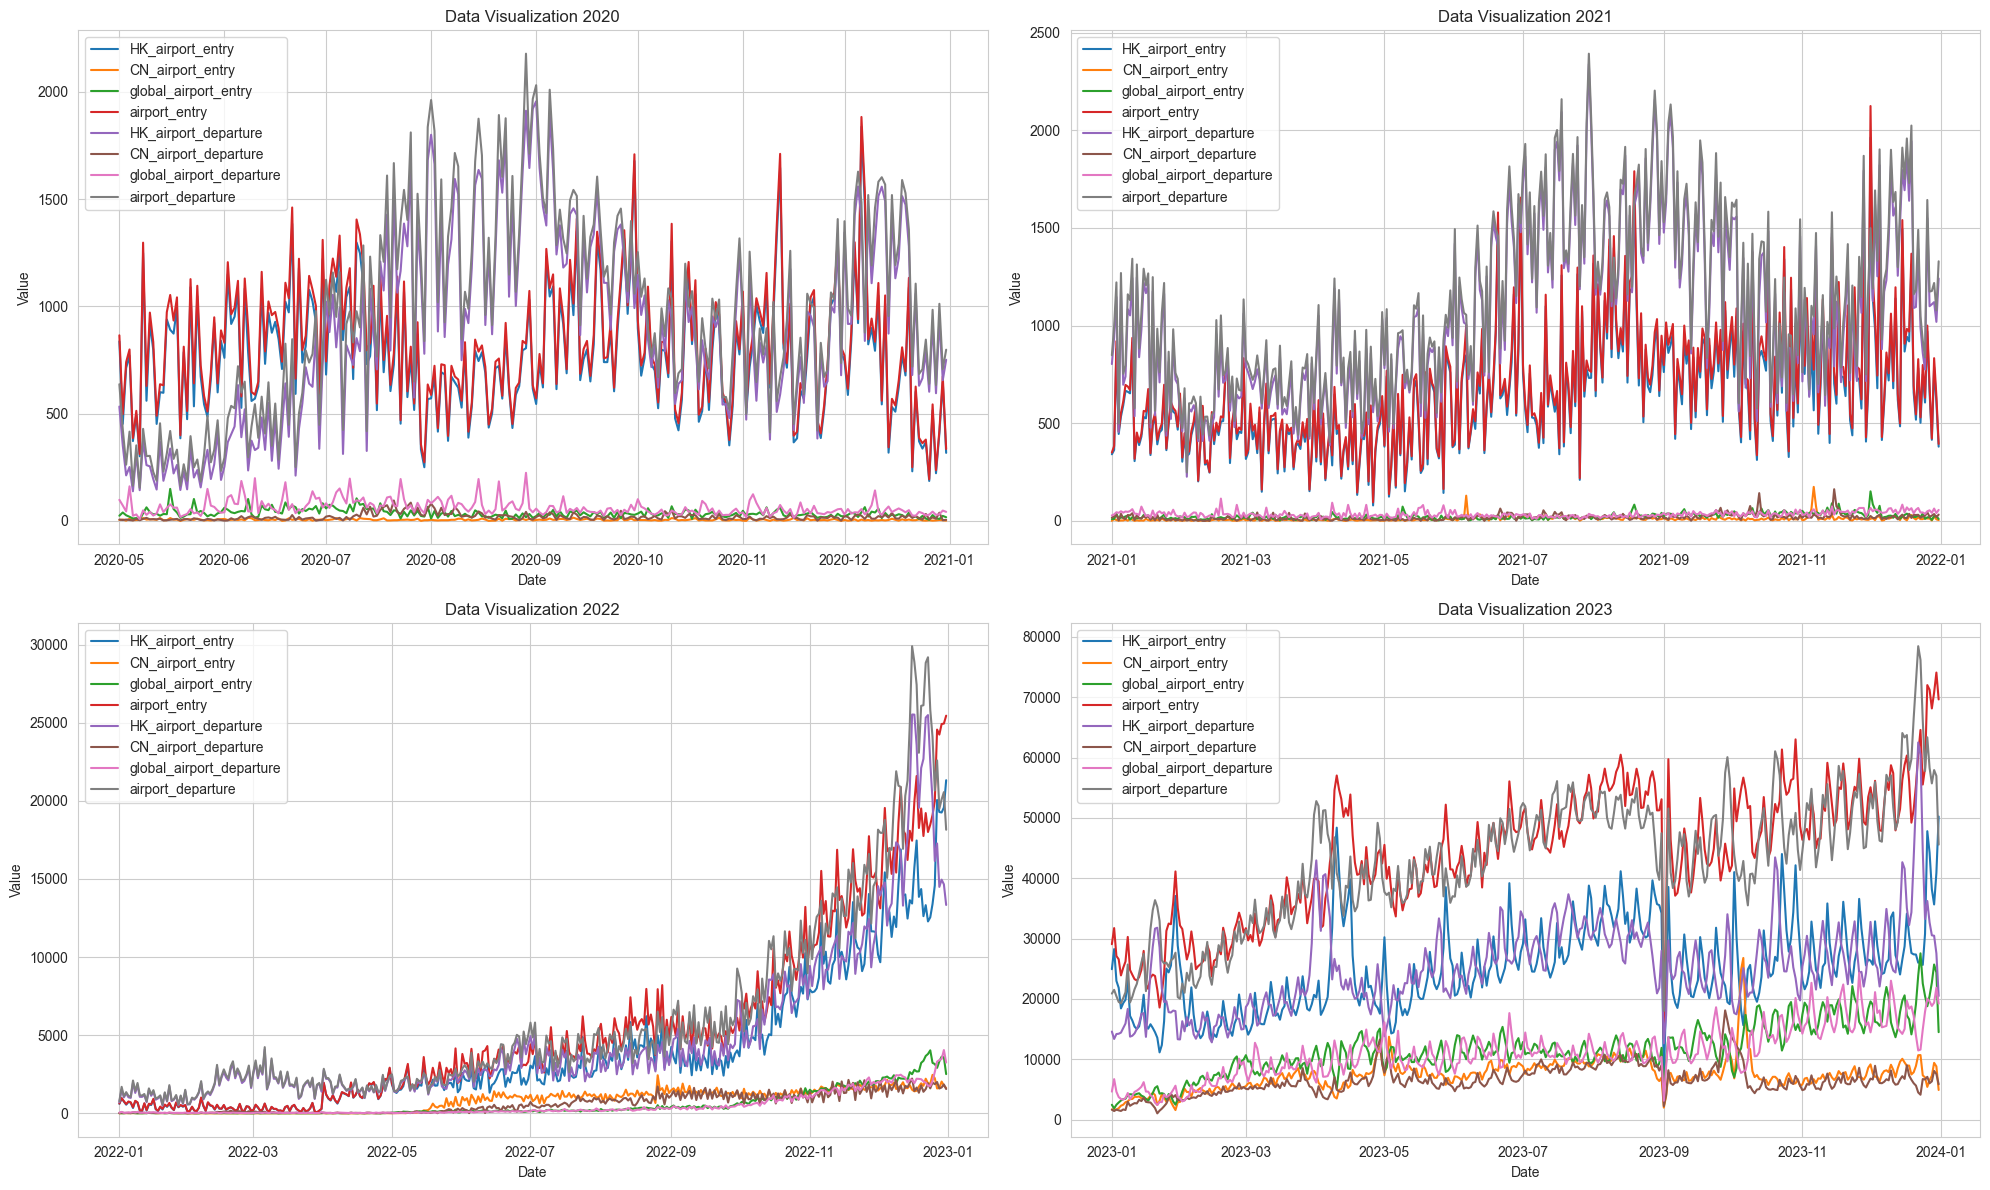

In [37]:
import matplotlib.pyplot as plt

# 设置图形大小并创建一个 2x2 的图表布局
fig, axs = plt.subplots(2, 2, figsize=(20, 12))


# 定义一个小函数来简化代码
def plot_subgraph(ax, df, title):
    for column in df.columns:
        if column != "date":
            ax.plot(df.index, df[column], label=column)
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.set_title(title)


# 分别绘制每年的数据
plot_subgraph(axs[0, 0], df2020, "Data Visualization 2020")
plot_subgraph(axs[0, 1], df2021, "Data Visualization 2021")
plot_subgraph(axs[1, 0], df2022, "Data Visualization 2022")
plot_subgraph(axs[1, 1], df2023, "Data Visualization 2023")

# 调整子图间距
plt.tight_layout()
plt.show()

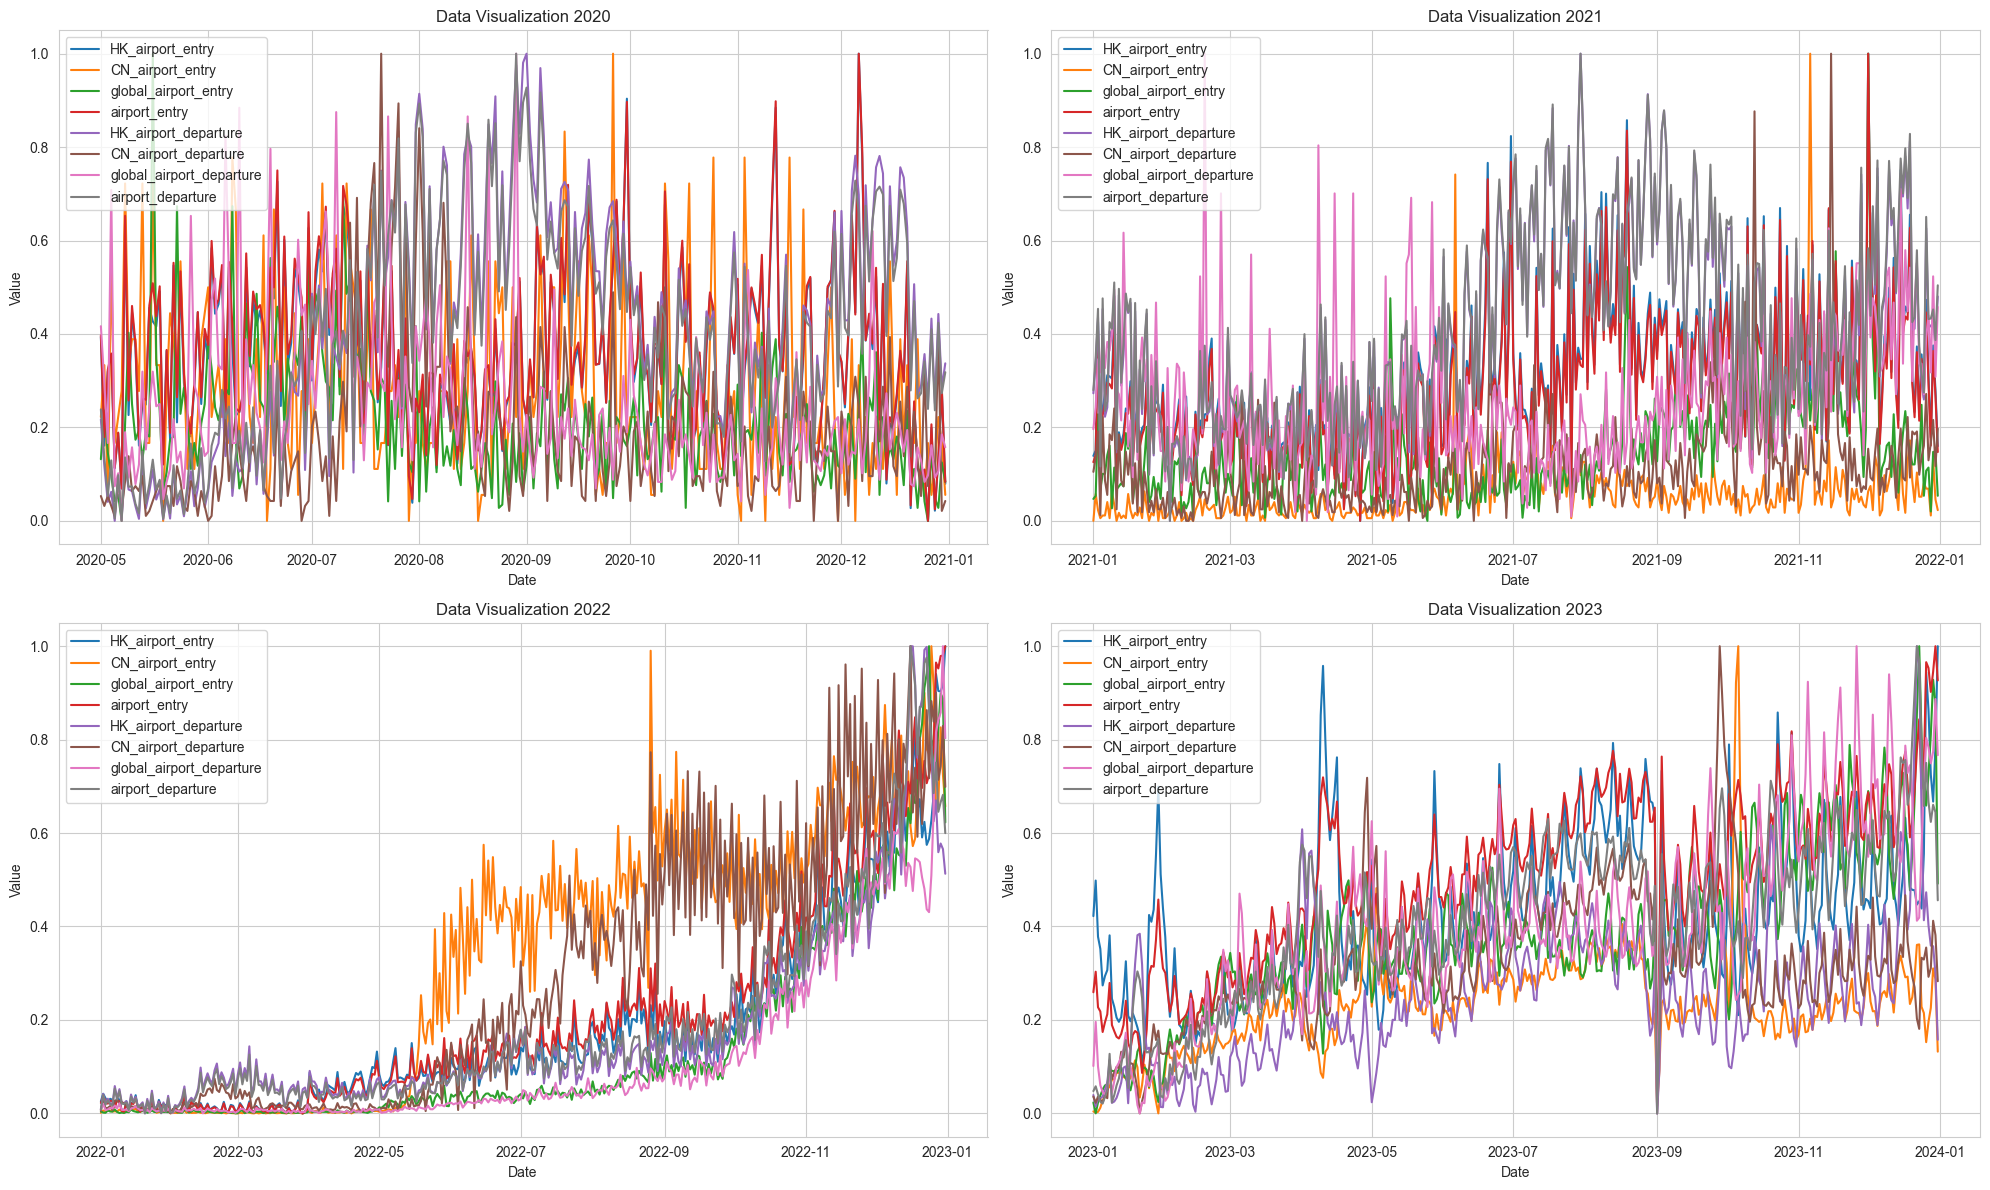

In [38]:
# 绘图代码，使用归一化后的数据
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# 分别绘制每年的数据
plot_subgraph(axs[0, 0], df2020_normalized, "Data Visualization 2020")
plot_subgraph(axs[0, 1], df2021_normalized, "Data Visualization 2021")
plot_subgraph(axs[1, 0], df2022_normalized, "Data Visualization 2022")
plot_subgraph(axs[1, 1], df2023_normalized, "Data Visualization 2023")

# 调整子图间距
plt.tight_layout()
plt.show()

In [39]:
import numpy as np
import pandas as pd
from dtaidistance import dtw
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# 假设 df 是你的DataFrame，并且所有列都是数值型数据
def matrix_plt(mat: pd.DataFrame, title="DTW Distance Matrix"):
    # 使用Seaborn绘制热图
    plt.figure(figsize=(8, 8))
    sns.heatmap(mat, annot=True, cmap="viridis", square=True, cbar_kws={"shrink": 0.7})
    plt.title(title)
    plt.show()


# dtw的绝对值没有意义，但是相对值有意义，所以进行归一化
def dtw_matrix(df, pdColumn, pdRow):
    # 创建一个空的DataFrame用于存储DTW距离
    mat = dtw.distance_matrix_fast(
        df.values.astype(np.float64).swapaxes(1, 0)
    )
    df = pd.DataFrame(
        data=mat, columns=df.columns, index=df.columns
    )
    # delete useless data
    df = df[pdRow]
    df = df.loc[pdColumn]
    # df_normalized = pd.DataFrame(MinMaxScaler().fit_transform(df.values), columns=df.columns, index=df.index)
    # 方法1：MinMax归一化
    # 方法2:进行log归一化
    dtw_matrix_log = np.log1p(df)
    # 加上column name
    # return df_normalized
    return dtw_matrix_log
    

# 3. 日度数据关联程度

(由于总计出入境，总计出境，总计入境与其他数据关联太小，从数据库中删除，不做分析）

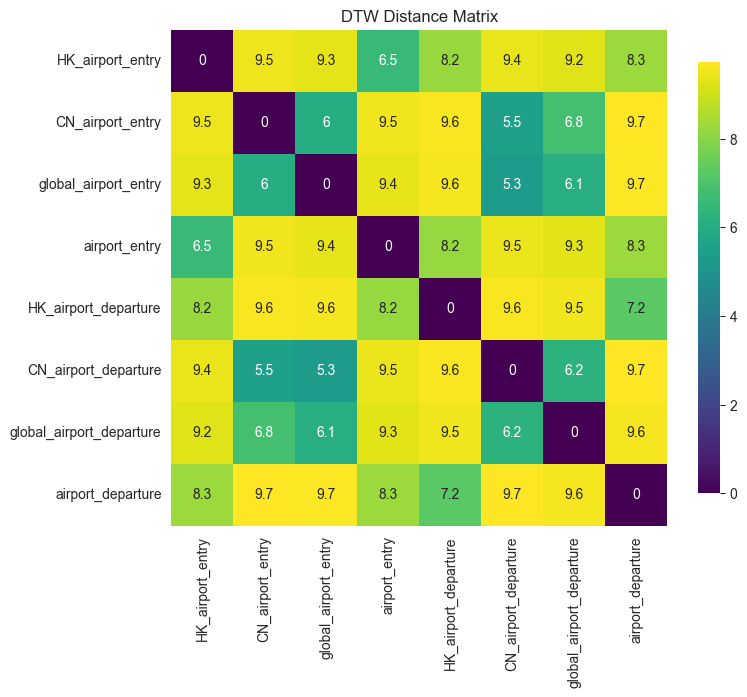

In [40]:
matrix_plt(dtw_matrix(dfAll, dfAll.columns, dfAll.columns))

从图中可以看出，我们把外国人香港机场入境（gl机场入境）设为baseline
可以发现和其关系最近的为cn机场出境入境，次深的为gl机场出境。
距离分别为200-300左右，其他的例如和gl机场出境的距离有1000

# 4. 月度数据关联程度
## 3.1 全月度

In [41]:
# 取出 < 2023-12 的hk月度数据
dfHkMonthly = get_formatted_data(f"select * from {table_hk_monthly} where date<'2024-01-01'", engine, hasDate=True)

dfShMonthly = get_formatted_data(f"select * from {table_sh_monthly} where date<'2024-01-01' and date>='2019-04-01'",
                                 engine, hasDate=True)

dfMonthly = pd.merge(dfHkMonthly, dfShMonthly, left_index=True, right_index=True)

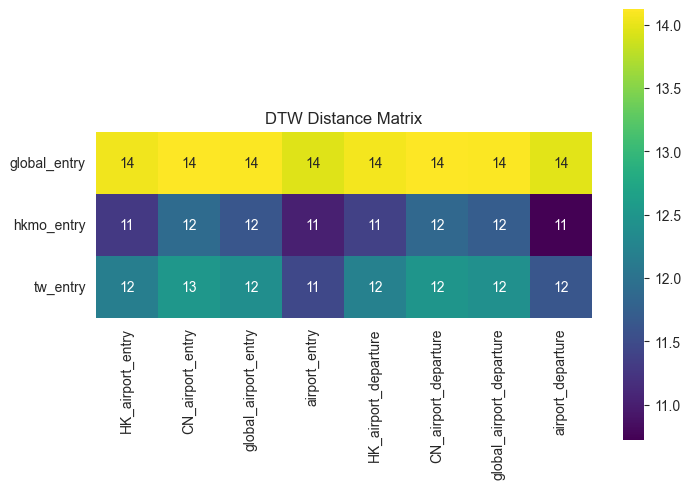

In [42]:
dfMat = dtw_matrix(dfMonthly, dfShMonthly.columns, dfHkMonthly.columns)

matrix_plt(dfMat)

## 3.2 后疫情时代

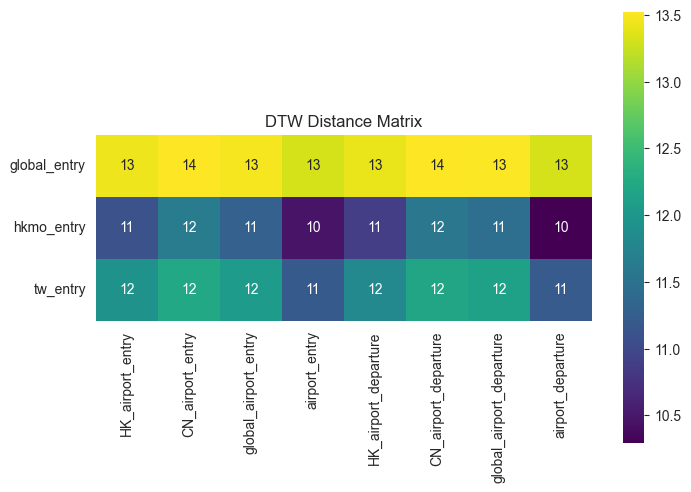

In [43]:
dfHkMonthly2023 = get_formatted_data(f"select * from {table_hk_monthly} where date<'2024-01-01' and date>='2023-01-01'",
                                     engine, hasDate=True)

dfShMonthly2023 = get_formatted_data(f"select * from {table_sh_monthly} where date<'2024-01-01' and date>='2023-01-01'",
                                     engine, hasDate=True)

dfMonthly2023 = pd.merge(dfHkMonthly2023, dfShMonthly2023, left_index=True,right_index=True)

matrix_plt(dtw_matrix(dfMonthly2023,dfShMonthly2023.columns, dfHkMonthly2023.columns))

# 3.3 非疫情时间

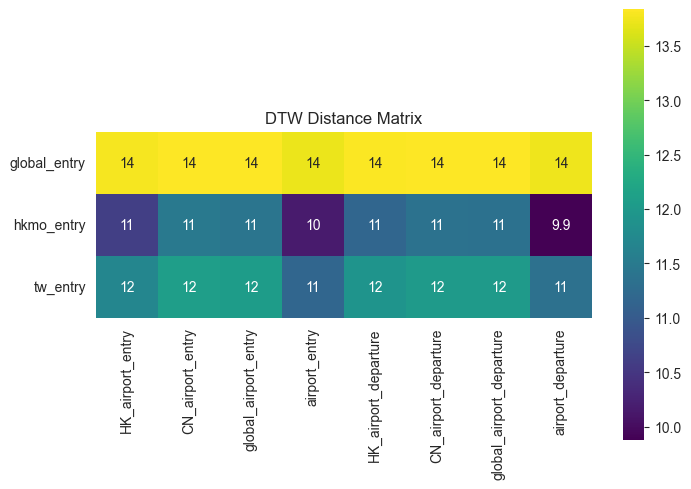

In [44]:
dfHkMonthly2019 = get_formatted_data(f"select * from {table_hk_monthly} where date<'2020-01-01' and date>='2019-01-01'",
                                     engine, hasDate=True)

dfShMonthly2019 = get_formatted_data(f"select * from {table_sh_monthly} where date<'2020-01-01' and date>='2019-01-01'",
                                     engine, hasDate=True)

dfMonthly2019 = pd.merge(dfHkMonthly2019, dfShMonthly2019, left_index=True,right_index=True)

matrix_plt(dtw_matrix(dfMonthly2019,dfShMonthly2019.columns, dfHkMonthly2019.columns))

# 3.5 结论

1. 在疫情期间
1.1 global_entry <-> CN_en / CN_dept, 由于有不合趋势的国庆出游峰值，次选GL_en / GL_dept
1.2 hkmo_entry <-> None, 大体上应该与HK_entry有关,选任意一个均可
1.3 tw_entry <-> CN_dept,同理，选择GL_en / HK_en
2. 在非疫情期间
1.1 global_entry <-> HK_en / HK_dept = HK_dept / GL_en
1.2 hkmo_entry <-> GL_en / GL_dept
1.3 tw_entry <-> GL_en / GL_dept = GL_en
4. 综上所述,使用GL_en预测

# 4 取数据

In [45]:
from sklearn.preprocessing import MinMaxScaler

# 选取baseline
groups = ["gl机场入境", "gl机场出境", "cn机场入境", "cn机场出境"]
contrib = [1, 1, 1, 1]  # equal contribution

querySelected = f"select * from {table_hk_selected} where date>='2023-01-01';"
dfSelected = pd.read_sql(querySelected, engine)

# minmax_scaler = MinMaxScaler()
# for col in dfSelected.columns:
#     if col != 'date':
#         dfSelected[col] = minmax_scaler.fit_transform(dfSelected[col].values.reshape(-1, 1))
#
# mat = dfSelected.drop(columns=['date']).values
# dfSelected['trend'] = minmax_scaler.inverse_transform(np.average(mat, axis=1, weights=contrib).reshape(-1,1))

# 写入数据库
# dfSelected.drop(columns=groups).to_sql('hk_pred_trend', con=engine, if_exists='replace', index=True)

NameError: name 'table_hk_selected' is not defined

In [ ]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(
    dfSelected["global_airport_entry"], model="addictive", period=7
)
decomposition.plot()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
plot_subgraph(axs, dfSelected, "Trend Visualization")
plt.show()
